In [1]:
import re
import json
import numpy as np
import pandas as pd
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.chains import QAGenerationChain
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
# Read
episode_id = "0333"
doc = pd.read_csv("audio_transcription/%s.txt"%episode_id,sep='\t')
doc.columns=['links','time','chunks']

# Clean text chunks 
doc['clean_chunks']=doc['chunks'].astype(str).apply(lambda x: x.strip())

# Write updated file (b/c we isolate sections for question-answer formulation below)
with open('audio_transcription/%s_text.txt'%episode_id, "w") as f:
    for i in doc.index:
        string = doc.loc[i,'clean_chunks']
        f.write(string + "\n") 

In [6]:
# Note: feeding complete file failed for non-obvious reasons (JSON error; searched at length for invalid chars but could not find)
# In any case, I fed small chunks of the dataset into the QA generation and it worked (and maybe improved the QA since inputs were selected 
filename = 'audio_transcription/0333_text_transformer.txt'
loader = TextLoader(filename)
doc_karpathy = loader.load()[0]
txt_transformer = doc_karpathy.page_content

filename = 'audio_transcription/0333_text_sw2dot0.txt'
loader = TextLoader(filename)
doc_karpathy = loader.load()[0]
txt_sw20 = doc_karpathy.page_content

filename = 'audio_transcription/0333_text_sd.txt'
loader = TextLoader(filename)
doc_karpathy = loader.load()[0]
txt_sd= doc_karpathy.page_content

chain = QAGenerationChain.from_llm(ChatOpenAI(temperature = 0))
qa_karpathy_transformer = chain.run(txt_transformer)

chain = QAGenerationChain.from_llm(ChatOpenAI(temperature = 0))
qa_karpathy_sw20 = chain.run(txt_sw20)

chain = QAGenerationChain.from_llm(ChatOpenAI(temperature = 0))
qa_karpathy_sd= chain.run(txt_sd)

qa_all = qa_karpathy_transformer + qa_karpathy_sw20 + qa_karpathy_sd
qa_all

[{'question': 'What is the transformer architecture in deep learning?',
  'answer': 'The transformer architecture is a neural network architecture that is general purpose and can process different sensory modalities like vision, audio, text, and video. It is simultaneously expressive in the forward pass, optimizable via backpropagation, gradient descent, and efficient high parallelism compute graph.'},
 {'question': 'What is a transformer and how is it designed?',
  'answer': 'A transformer is a series of blocks with attention and a multilayer perceptron. It is designed to be very expressive in a forward pass, optimizable in a backward pass, and efficient in hardware. The residual connections support the ability to learn short algorithms fast and first, and then gradually extend them longer during training.'},
 {'question': 'What is a transformer architecture and why is it important?',
  'answer': 'A transformer architecture is a type of neural network that is remarkably resilient and 

`Notes -` 

https://langchain.readthedocs.io/en/latest/use_cases/evaluation/qa_generation.html

In [22]:
from langchain.llms import OpenAI
from langchain.vectorstores import Chroma
from langchain.vectorstores import FAISS
from langchain.chains import VectorDBQA
from langchain.evaluation.qa import QAEvalChain

def make_splits(chunk_size,overlap,texts,links,episode_id):

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap) 
    splits = text_splitter.split_text(texts)
    bins = np.linspace(0,len(links)-1,len(splits),dtype=int)
    sampled_links = [links[i] for i in bins]
    metadatas=[{"source":link,"id":episode_id,"link":link} for link in sampled_links]
    db = FAISS.from_texts(splits, OpenAIEmbeddings(), metadatas=metadatas) 
    chain = VectorDBQA.from_chain_type(llm=ChatOpenAI(temperature=0), 
                                       chain_type="stuff", 
                                       vectorstore=db, 
                                       input_key="question")
    
    return chain 

episode_id = "0333"
doc = pd.read_csv("audio_transcription/%s.txt"%episode_id,sep='\t')
doc.columns=['links','time','chunks']
doc['clean_chunks']=doc['chunks'].astype(str).apply(lambda x: x.strip())

chains = {}
overlap = 50
for chunk_size in [250,500,1000,2000,3000]:
    chain = make_splits(chunk_size,overlap,list(doc['clean_chunks']),list(doc['links']),episode_id)
    chains[chunk_size] = chain


In [36]:
def run_eval(chain):
    predictions = []
    predicted_dataset = []
    for data in qa_all:
        new_data = {"question": data["question"],"answer": data["answer"]}
        predictions.append(chain(new_data))
        predicted_dataset.append(new_data)
    return predictions,predicted_dataset

predictions_list = []
scores_list = []
eval_chain = QAEvalChain.from_llm(llm=ChatOpenAI(temperature=0))
for chunk_size in [250,500,1000,2000,3000]:
    predictions,predicted_dataset=run_eval(chains[chunk_size])
    predictions_list.append(predictions)
    graded_outputs = eval_chain.evaluate(predicted_dataset, predictions, question_key="question", prediction_key="result")
    scores_list.append(graded_outputs)

In [35]:
# 250 -
graded_outputs

[{'text': 'INCORRECT'},
 {'text': 'INCORRECT'},
 {'text': 'CORRECT'},
 {'text': 'CORRECT'},
 {'text': 'CORRECT'},
 {'text': 'INCORRECT'},
 {'text': 'INCORRECT'}]

In [38]:
stor=pd.DataFrame()
for i,chunk_size in enumerate([250,500,1000,2000,3000]):
    d=scores_list[i]
    incorrect_counts = []
    for dictionary in d:
        if dictionary['text'] == 'INCORRECT':
            incorrect_counts.append(1)
        else:
            incorrect_counts.append(0)
    stor.loc[chunk_size,'num_incorrect']=sum(incorrect_counts)

In [42]:
stor['pct_incorrect'] = stor['num_incorrect'] / 7

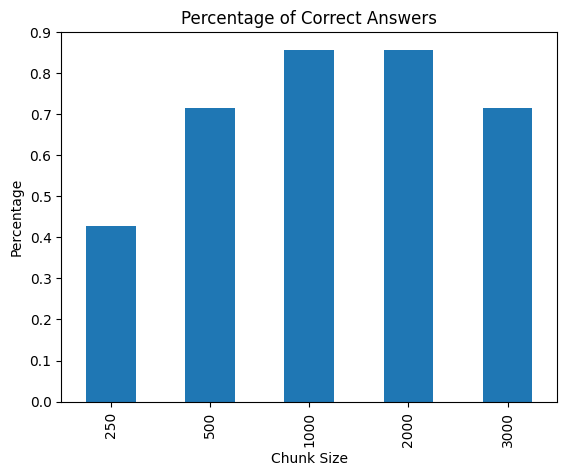

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
stor['pct_correct'] = 1 - stor['pct_incorrect']
stor['pct_correct'].plot(kind='bar')
plt.title('Percentage of Correct Answers')
plt.xlabel('Chunk Size')
plt.ylabel('Percentage')
plt.show()

In [46]:
stor

,num_incorrect,pct_incorrect
250,4.0,0.571429
500,2.0,0.285714
1000,1.0,0.142857
2000,1.0,0.142857
3000,2.0,0.285714
